# Indonesian Sentiment Polarity Using Lexicon and LSTM

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    horizontal-align: middle;
}
h1,h2 {
    text-align: center;
    background-color: black;
    padding: 20px;
    margin: 0;
    color: yellow;
    font-family: ariel;
    border-radius: 80px
}

h3 {
    text-align: center;
    border-style: solid;
    border-width: 3px;
    padding: 12px;
    margin: 0;
    color: black;
    font-family: ariel;
    border-radius: 80px;
    border-color: gold;
}

body, p {
    font-family: ariel;
    font-size: 15px;
    color: charcoal;
}
div {
    font-size: 14px;
    margin: 0;

}

h4 {
    padding: 0px;
    margin: 0;
    font-family: ariel;
    color: purple;
}
</style>
""")

In [1]:
# Import some libraries

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')

#!pip install twint
#import twint
#import nest_asyncio
#nest_asyncio.apply()

import datetime as dt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, LSTM
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [2]:
# Import dataframe
df = pd.read_csv('comments.csv')
df

,comments
0,Kak najwa sihab tolong di sampaikan derita rak...
1,"Ngak lah, SDH berpolitisasi .."
2,Dari kacamata banteng
3,Harusnya pemerintahan perlu kandudat kandudat ...
4,Kayaknya pemerintahan perlu belajar sama mbk n...
...,...
4559,Sepak bola tidak bisa terlepas dengan politik bro
4560,Pertama
4561,Ken bae ulah di Indonesia lier
4562,"""Selamat menunaikan ibadah puasa yang ke 7 sem..."


In [3]:
# Some functions for preprocessing text

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers

    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower() 
    return text

def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text) 
    return text

def filteringText(text): # Remove stopwors in a text
    listStopwords = set(stopwords.words('indonesian'))
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered 
    return text

def stemmingText(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(word) for word in text]
    return text

def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

In [4]:
# Preprocessing youtube data

df['text_clean'] = df['comments'].apply(cleaningText)
df['text_clean'] = df['text_clean'].apply(casefoldingText)
df.drop(['comments'], axis = 1, inplace = True)

df['text_preprocessed'] = df['text_clean'].apply(tokenizingText)
df['text_preprocessed'] = df['text_preprocessed'].apply(filteringText)
df['text_preprocessed'] = df['text_preprocessed'].apply(stemmingText)

# drop duplicates/spams tweets
df.drop_duplicates(subset = 'text_clean', inplace = True)

In [5]:
# Export to csv file
df.to_csv('ytcomments_data_clean.csv', index = False, header = True,index_label=None)
df

,text_clean,text_preprocessed
0,kak najwa sihab tolong di sampaikan derita rak...,"[kak, najwa, sihab, tolong, derita, rakyat, in..."
1,ngak lah sdh berpolitisasi,"[ngak, sdh, politisasi]"
2,dari kacamata banteng,"[kacamata, banteng]"
3,harusnya pemerintahan perlu kandudat kandudat ...,"[perintah, kandudat, kandudat, muda, biar, pik..."
4,kayaknya pemerintahan perlu belajar sama mbk n...,"[kayak, perintah, ajar, mbk, nanaatau, perinta..."
...,...,...
4559,sepak bola tidak bisa terlepas dengan politik bro,"[sepak, bola, lepas, politik, bro]"
4560,pertama,[]
4561,ken bae ulah di indonesia lier,"[ken, bae, ulah, indonesia, lier]"
4562,selamat menunaikan ibadah puasa yang ke semog...,"[selamat, tunai, ibadah, puasa, moga, lindung,..."


In [6]:
# Determine sentiment polarity of tweets using indonesia sentiment lexicon (source : https://github.com/fajri91/InSet)

# Loads lexicon positive and negative data
lexicon_positive = dict()
import csv
with open('lexicon_positive.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
import csv
with open('lexicon_negative.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
        

In [7]:
# Function to determine sentiment polarity of tweets        
def sentiment_analysis_lexicon_indonesia(text):
    for word in text:
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
    polarity=''
    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'
    return score, polarity

In [8]:
# Results from determine sentiment polarity of tweets

results = df['text_preprocessed'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df['polarity_score'] = results[0]
df['polarity'] = results[1]
print(df['polarity'].value_counts())

# Export to csv file
df.to_csv('ytcomments_data_clean_polarity.csv', index = False, header = True,index_label=None)

df

negative    2861
positive     957
neutral      625
Name: polarity, dtype: int64


,text_clean,text_preprocessed,polarity_score,polarity
0,kak najwa sihab tolong di sampaikan derita rak...,"[kak, najwa, sihab, tolong, derita, rakyat, in...",-28,negative
1,ngak lah sdh berpolitisasi,"[ngak, sdh, politisasi]",0,neutral
2,dari kacamata banteng,"[kacamata, banteng]",-3,negative
3,harusnya pemerintahan perlu kandudat kandudat ...,"[perintah, kandudat, kandudat, muda, biar, pik...",-4,negative
4,kayaknya pemerintahan perlu belajar sama mbk n...,"[kayak, perintah, ajar, mbk, nanaatau, perinta...",-3,negative
...,...,...,...,...
4559,sepak bola tidak bisa terlepas dengan politik bro,"[sepak, bola, lepas, politik, bro]",-6,negative
4560,pertama,[],0,neutral
4561,ken bae ulah di indonesia lier,"[ken, bae, ulah, indonesia, lier]",-3,negative
4562,selamat menunaikan ibadah puasa yang ke semog...,"[selamat, tunai, ibadah, puasa, moga, lindung,...",20,positive


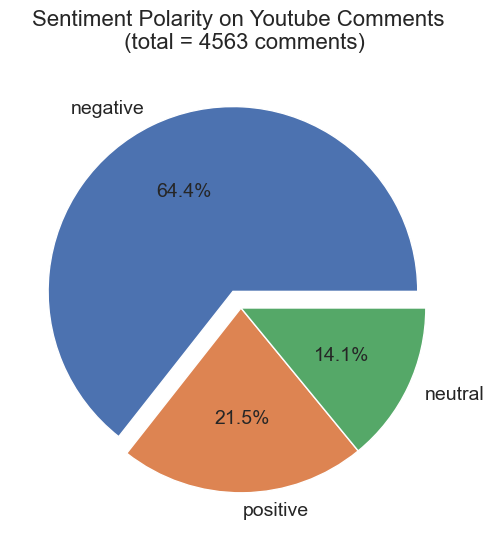

In [9]:
fig, ax = plt.subplots(figsize = (6, 6))
sizes = [count for count in df['polarity'].value_counts()]
labels = list(df['polarity'].value_counts().index)
explode = (0.1, 0, 0)
ax.pie(x = sizes, labels = labels, autopct = '%1.1f%%', explode = explode, textprops={'fontsize': 14})
ax.set_title('Sentiment Polarity on Youtube Comments \n (total = 4563 comments)', fontsize = 16, pad = 20)
plt.show()

In [10]:
# Top 10 Positive Comments

pd.set_option('display.max_colwidth', 3000)
positive_comments = df[df['polarity'] == 'positive']
positive_comments = positive_comments[['text_clean', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=False).reset_index(drop = True)
positive_comments.index += 1
positive_comments[0:10]

,text_clean,polarity_score,polarity
1,kalau israel sampe ngga dibolehin ikut piala dunia bisa jadi kita yg diperangin israel dan negara lainnya mungkin ga si ka najwa indonesia bisa semakin dibenci negara lainnya karena urusan yg kelihatanya sepele dlm dunia politik negara kita tpi menurut rakyat itu sungguhsungguh sangat mengecewakan semua rakyat indonesia khususnya pemain timnas kita dan pecinta sepak bola negara kita ingat untuk para pejabat negara kita sebelum bertindak ditelusuri dlu akibat dampak negatif dan positif untuk negara kita ingat negara indonesia kita punya dasar negara yaitu pancasila ketuhanan yg maha esa yg artinya keyakinan akan adanya tuhan yang maha esa yang menjadi dasar moral dan etika dalam kehidupan bernegara dan berbangsa yg berarti kita tidak boleh merasa diri kita paling benar pikirkan lah bangsamu yaitu bangsa indonesia bukan bangsa orang lain percayalah kepada tuhan yg maha esa bahwa semua sudah diatur sama tuhan kita yaitu allah swt kemanusiaan yang adil dan beradab yg artinya nilai suatu kesadaran sikap moral dan tingkah laku manusia yang didasarkan pada potensi hati nurani manusia dalam hubungan dengan normanorma dan kebudayaan sila ini berlaku untuk diri sendiri juga sesama manusia dan lingkungannya ingat sekali lagi sila ini berlaku juga untuk sesama manusia yaitu rakyat indonesia dan lingkungan linkungan kita adalah indonesia persatuan indonesia yakni sebagai berikut mampu menempatkan persatuan kesatuan serta kepentingan dan keselamatan bangsa dan negara sebagai kepentingan bersama di atas kepentingan pribadi dan golongan sanggup dan rela berkorban untuk kepentingan negara dan bangsa apabila diperlukan persatuan dan kepentingan negara bila mana negara kita menjadi dibenci orang karena masalah sepele persepakbolaan dan kita jdi pusat penjajahan mau gimana cba berarti tidak ada persatuan kesatuan serta kepentingan dan keselamatan bangsa sebagai kepentingan bersama kerakyatan yang dipimpin oleh hikmat kebijaksanaan dalam permusyawaratanperwakilan kerakyatan” yang dianut oleh bangsa indonesia bukan hanya mencari suara terbanyak saja mengapa begitu karena bangsa indonesia menganut paham “kerakyatan” harus sesuai dengan apa yang tercantum di dalam pancasila terutama pada sila ke adapun bunyi dari sila ke yakni “ kerakyatan yang dipimpin oleh hikmat kebijaksanaan dalam permusyawaratanperwakilan” berdasarkan isi dari sila ke bisa dikatakan bahwa “kerakyatan” yang dijalankan harus sesuai dengan kejujuran kesucian kebenaran kebaikan dan keindahan dalam menerapkan sila ke ini diperlukan sila ke yang berbunyi “ketuhanan yang maha esa” hal ini dikarenakan nilai pada sila ke akan membuat setiap individu melindungi “kerakyatan” dari halhal yang dapat merugikan bangsa dan negara indonesia jadi jangan mementingkan ego sendiri atau kepentingan politik sendiri keadilan sosial bagi seluruh rakyat indonesiabagi rakyat indonesia keadilan adalah hal yang sangat penting makna sila ke dalam pancasila adalah menegaskan bahwasanya keadilan sosial merupakan keadilan...,117,positive
2,teks unda ngundang dasar alinea i bahwa sesungguhnya kemerdekaan itu ialah hak segala bangsa dan oleh sebab itu maka penjajahan di atas dunia harus dihapuskan karena tidak sesuai dengan perikemanusiaan dan perikeadilan alinea ii dan perjuangan pergerakan kemerdekaan indonesia telah sampailah kepada saat yang berbahagia dengan selamat sentausa mengantarkan rakyat indonesia ke depan pintu gerbang kemerdekaan negara indonesia yang merdeka bersatu berdaulat adil dan makmur alinea iii atas berkat rakhmat allah yang maha kuasa dan dengan didorongkan oleh keinginan luhur supaya berkehidupan kebangsaan yang bebas maka rakyat indonesia menyatakan dengan ini kemerdekaannya alinea iv kemudian daripada itu untuk membentuk suatu pemerintah negara indonesia yang melindungi segenap bangsa indonesia dan seluruh tumpah darah indonesia dan untuk memajukan kesejahteraan umum mencerdaskan kehidupan bangsa dan ikut melaksanakan ketertiban dunia yang berdasark

In [11]:
#Top 10 Negative Comments

pd.set_option('display.max_colwidth', 3000)
negative_comments = df[df['polarity'] == 'negative']
negative_comments = negative_comments[['text_clean', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=True)[0:10].reset_index(drop = True)
negative_comments.index += 1
negative_comments[0:10]

,text_clean,polarity_score,polarity
1,najwa harus tahu israel negara berdaulat sejak dan diakui ppb terkait sepak bola israel anggota tetap uefa dan terdaftar di uefa jadi pertandingan israel dibawah naungan uefa organisasi sepak bola eropa yang di akui fifaterkait sepak bola palestina dimana palestina anggota tetap afc organisasi sepak bola asia yang di akui fifa lalu ada yang berkata fifa terapkan sangsi ganda rusia dan israel dimana rusia disangsi karena memerangi ukraina israel memerangi palestina tdk sangsi fifa wowww itu menjadi dalihalibi kita indonesia kepada fifa mari kita lihat permasalahan sepak bola rusia sehingga disangsi fifa feb rusia menyerang dengan rudal kranat menghujani peluru pada ukraina feb anggota tetap uefa mengambil putusan mengsangsi rusia sebagai anggota atas permintaan ukraina sebagai anggota tetapitu terjadi feb putusan sangsi di keluarkan uefa karna mengingat jadwal pertandingan rusia vs polandia maret kualifikasi piala dunia qatar di batalkan uefa atas permintaan anggota tetap uefa fifa hanya menindaklajuti putusan uefa yang di ambil feb maka maret fifa mengambil putusan rusia tdk bole mengikuti kualifikasi piala dunia dan kompotisi eropachampion piala uefarusiaukrainaisrael anggota tetap uefa palestina anggota tetap afc organisasi sepak bola asia mana anggota tetap afc meminta israel di sangsi fifa karna anggota tetap afc sadar palestinaisrael dlm sepak bola sudah beda kamar israel uefa palestina afc tetap pertanyaan fifa terapkan sangsi ganda israel tdk diminta oleh anggota tetap uefa untuk disangsi fifa dan fifa tdk memberikan sangsi pada israel karna memerangi palestina karna afc tdk meminta sebab itu lihat secara jernih baru komentar,-120,negative
2,qatar anehnya di g kok indonesia gak ngusir rusia padahal banyak protes juga waktu itu indonesia itu gak netral bro indonesia itu sekutunya rusia dan china inget gak waktu kemenlu kelepasan ikut mengutuk rusia terus pada rame mengkoreksi pernyataan arab saudi nyerang yaman indonesia diem aja china melakukan diskriminasi terhadap muslim uyghur indonesia gak ngomong apa indonesia itu mendukung penjajahan asal yang menjajah adalah teman sendiri tapi kalo yg menjajah itu musuh langsung pada virtue signaling amerika juga menjajah negara timur tengah gak ada tuh indonesia mengambil sikap ngusir investor dari amerika intinya ini bukan masalah konstitusi ini masalah orang yg cari panggung untuk tampil orang indonesia emang hobinya menyabotase diri sendiri paling gak bisa diam ketika ada sesuatu yang berjalan mulus dan lancar nggak ribut nggak asyik nggak bisa bersikap profesional lagian emangnya negara yg jahat di dunia itu cuma israel gak inget waktu sukarno tibatiba nyuruh ganyang malaysia tanpa sebab gak inget kalo sebenarnya indonesia juga ngambil papua dan timor leste dengan paksa demi keamanan dan keutuhan perbatasan negara kalo kita mau bicara siapa jahat siapa yg baik bisa panjang daftarnya semua punya catatan hitam makanya daripada ribet mendingan sepakbola ya sepakbola aja lagian piala dunia cuma sebulan dan israel itu cuma satu dari negara yg ikut gara pindah tuan rumah negara peserta yg lain jadi pada repot juga dengan persiapannya bukankah dalam agama islam dianjurkan untuk memuliakan tamu kasian komunitas sepakbola indonesia yang dikorbankan di atas altar idealisme layaknya dukun yg menumbalkan orang tidak bersalah demi mendapatkan pesugihan qatar aja sampe membuka penerbangan dari doha ke tel aviv selama piala dunia demi memberi kesempatan kepada jurnalis dan warga israel untuk menonton dan meliput padahal mereka juga tetap mendukung palestina sampai sekarang qatar bisa bersikap dewasa dan menempatkan sesuatu pada tempatnya lebih baik mana idealisme atau sepakbola duanya sama baik asal ditempatkan dengan semestinya ini opini saya,-111,negative
3,​ halah seberapa imbasnya kok kaya anda katakan kiamat aja di indonesia kau kira masyarakat indonesia kerja cari duid dari event ini saya rasa tidak lah gimana ga dibawa dari kita lahir sampai sek

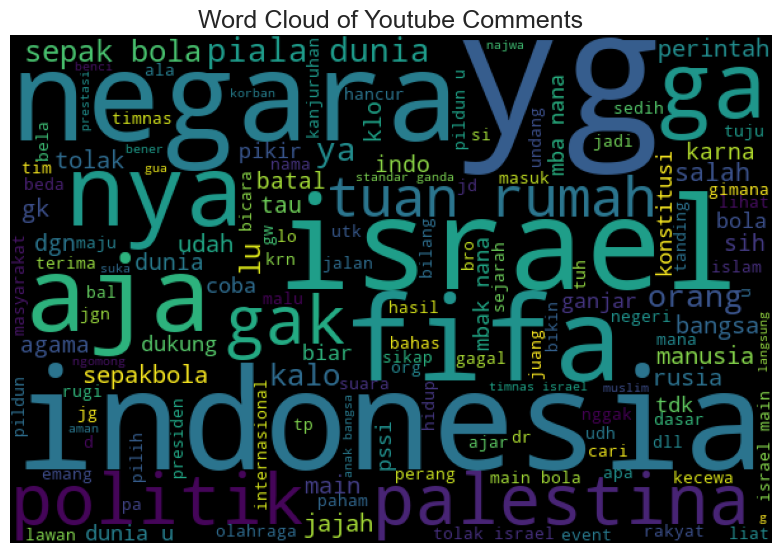

In [12]:
# Visualize word cloud

list_words=''
for comments in df['text_preprocessed']:
    for word in comments:
        list_words += ' '+(word)
        
wordcloud = WordCloud(width = 600, height = 400, background_color = 'black', min_font_size = 10).generate(list_words)
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_title('Word Cloud of Youtube Comments', fontsize = 18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

In [13]:
# Function to group all positive/negative words
def words_with_sentiment(text):
    positive_words=[]
    negative_words=[]
    for word in text:
        score_pos = 0
        score_neg = 0
        if (word in lexicon_positive):
            score_pos = lexicon_positive[word]
        if (word in lexicon_negative):
            score_neg = lexicon_negative[word]
        
        if (score_pos + score_neg > 0):
            positive_words.append(word)
        elif (score_pos + score_neg < 0):
            negative_words.append(word)
            
    return positive_words, negative_words

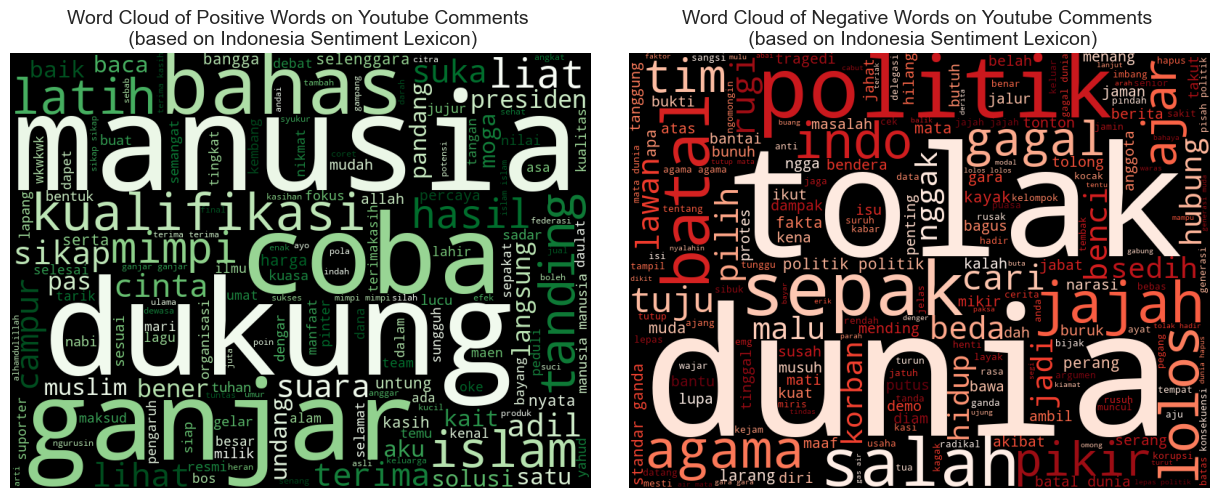

In [14]:
# Visualize positive and negative word cloud

sentiment_words = df['text_preprocessed'].apply(words_with_sentiment)
sentiment_words = list(zip(*sentiment_words))
positive_words = sentiment_words[0]
negative_words = sentiment_words[1]

fig, ax = plt.subplots(1, 2,figsize = (12, 10))
list_words_postive=''
for row_word in positive_words:
    for word in row_word:
        list_words_postive += ' '+(word)
wordcloud_positive = WordCloud(width = 800, height = 600, background_color = 'black', colormap = 'Greens'
                               , min_font_size = 10).generate(list_words_postive)
ax[0].set_title('Word Cloud of Positive Words on Youtube Comments \n (based on Indonesia Sentiment Lexicon)', fontsize = 14)
ax[0].grid(False)
ax[0].imshow((wordcloud_positive))
fig.tight_layout(pad=0)
ax[0].axis('off')

list_words_negative=''
for row_word in negative_words:
    for word in row_word:
        list_words_negative += ' '+(word)
wordcloud_negative = WordCloud(width = 800, height = 600, background_color = 'black', colormap = 'Reds'
                               , min_font_size = 10).generate(list_words_negative)
ax[1].set_title('Word Cloud of Negative Words on Youtube Comments \n (based on Indonesia Sentiment Lexicon)', fontsize = 14)
ax[1].grid(False)
ax[1].imshow((wordcloud_negative))
fig.tight_layout(pad=0)
ax[1].axis('off')

plt.show()

# Sentiment Analysis Using Long short term memory network (LSTM)

## Preprocessing Text Data

In [15]:
# Make text preprocessed (tokenized) to untokenized with toSentence Function
X = df['text_preprocessed'].apply(toSentence) 
max_features = 5000

# Tokenize text with specific maximum number of words to keep, based on word frequency
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X)
X.shape

(4443, 358)

In [16]:
# Encode target data into numerical values
polarity_encode = {'negative' : 0, 'neutral' : 1, 'positive' : 2}
y = df['polarity'].map(polarity_encode).values

# Split the data (with composition data train 80%, data test 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3554, 358) (3554,)
(889, 358) (889,)


In [17]:
# Create model function with default hyperparameter values

def create_model(embed_dim = 16, hidden_unit = 16, dropout_rate = 0.2, optimizers = Adam, learning_rate = 0.001):
    model = Sequential()
    model.add(Embedding(input_dim = max_features, output_dim = embed_dim, input_length = X_train.shape[1]))
    model.add(LSTM(units = hidden_unit, activation = 'tanh'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 3, activation = 'softmax'))
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizers(lr = learning_rate), metrics = ['accuracy'])
    print(model.summary())
    return model

In [ ]:
# # Hyperparameter tuning (to know the best hyperparameter for this model)

# # Wrapper model with default hyperparameter values
model = KerasClassifier(build_fn = create_model, epochs = 25, batch_size=128) 

# # Hyperparameters
embed_dim = [32, 64]
hidden_unit = [16, 32, 64]
dropout_rate = [0.2]
optimizers = [Adam, RMSprop]
learning_rate = [0.01, 0.001, 0.0001]
epochs = [10, 25, 50, 100]
batch_size = [128, 256]
param_grid = dict(embed_dim = embed_dim, hidden_unit = hidden_unit, dropout_rate = dropout_rate,
                   learning_rate = learning_rate, optimizers = optimizers, epochs = epochs, batch_size = batch_size)

# # Evaluation model with GridSearchCV to know what the best hyperparameter for model 
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3)
grid_result = grid.fit(X_train, y_train)

results = pd.DataFrame()
results['means'] = grid_result.cv_results_['mean_test_score']
results['stds'] = grid_result.cv_results_['std_test_score']
results['params'] = grid_result.cv_results_['params']
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
results.to_csv(r'gridsearchcv_results.csv.csv', index = False, header = True)
results.sort_values(by='means', ascending = False).reset_index(drop=True)

In [ ]:
# Results from hyperparameter tuning
results = pd.read_csv('data/gridsearchcv_results.csv')
results.sort_values(by='means', ascending = False).reset_index(drop=True)

In [36]:
# From results above, we know the best hyperparameter for this model is :
# {'batch_size': 128, 'dropout_rate': 0.2, 'embed_dim': 32, 'epochs': 10, 'hidden_unit': 16, 'learning_rate': 0.001, 'optimizers': <class 'keras.optimizers.RMSprop'>}

# Create the model with the best hyperparameter which has been determined
model = KerasClassifier(build_fn = create_model,
                        # Model Parameters
                        dropout_rate = 0.2,
                        embed_dim = 64,
                        hidden_unit = 32,
                        optimizers = Adam,
                        learning_rate = 0.001,
                   
                        # Fit Parameters
                        epochs=10, 
                        batch_size=64,
                        # Initiate validation data, which is 10% data from data train. It's used for evaluation model
                        validation_split = 0.1)
                         

model_prediction = model.fit(X_train, y_train)

C:\Users\USER\AppData\Local\Temp\ipykernel_6964\3314134587.py:5: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = create_model,


Model: "sequential_116"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_116 (Embedding)   (None, 358, 64)           320000    
                                                                 
 lstm_116 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_116 (Dropout)       (None, 32)                0         
                                                                 
 dense_116 (Dense)           (None, 3)                 99        
                                                                 
Total params: 332,515
Trainable params: 332,515
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
50/50 [==============================] - 17s 272ms/step - loss: 0.9121 - accuracy: 0.6413 - val_loss: 0.8092 - val_accuracy: 0.6713
Epoch 2/10
50/50 [============

## Notice that I'm not letting the hyperparameter tuning be done; it takes too long to complete, so in the following code I just use a random parameter.

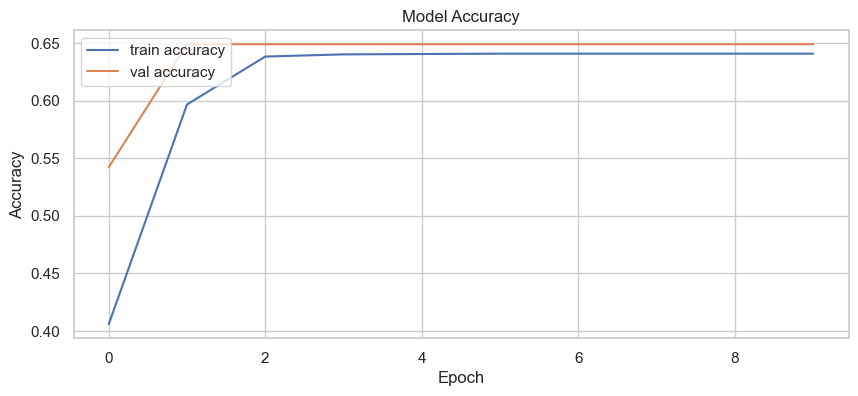

In [34]:
# Visualization model accuracy (train and val accuracy)

fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(model_prediction.history['accuracy'], label = 'train accuracy')
ax.plot(model_prediction.history['val_accuracy'], label = 'val accuracy')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(loc = 'upper left')
plt.show()

28/28 [==============================] - 4s 70ms/step
Model Accuracy on Test Data: 0.750281214848144


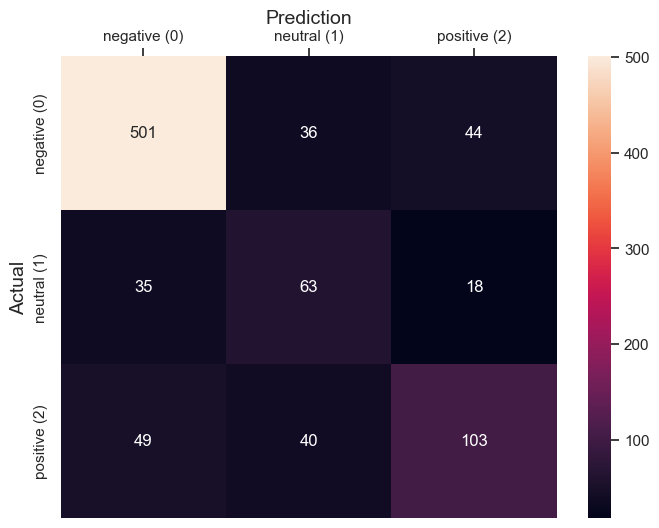

In [37]:
# Predict sentiment on data test by using model has been created, and then visualize a confusion matrix


y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Model Accuracy on Test Data:', accuracy)
confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(confusion_matrix(y_true = y_test, y_pred = y_pred), fmt = 'g', annot = True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediction', fontsize = 14)
ax.set_xticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
ax.set_ylabel('Actual', fontsize = 14)
ax.set_yticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
plt.show()

In [38]:
# Results from prediction sentiment on data test
text_clean = df['text_clean']
text_train, text_test = train_test_split(text_clean, test_size = 0.2, random_state = 0)
result_test = pd.DataFrame(data = zip(text_test, y_pred), columns = ['text', 'polarity'])
polarity_decode = {0 : 'Negative', 1 : 'Neutral', 2 : 'Positive'}
result_test['polarity'] = result_test['polarity'].map(polarity_decode)
pd.set_option('max_colwidth', 300)
result_test

,text,polarity
0,yang ditolak israel yg korban staff timnas pemain yg uda latihan shin tae yongtukang parkir gbk calo tiket stadion tukang jual jerseytukang jual kopi gbk erik tohir yg uda jauh² ke zyurich habis ini koar koar lagi utang negara kok nambah trus salahin lagi pemerintah salahin pembangunan jalan s...,Negative
1,woyyyyy piala dunia itu bukan urusany gubenur mendingan loe urusin daerah loe masing,Negative
2,dunia tutup mata utk palestina,Negative
3,negeri ini cocoknya ngaji saja dirumah 😊,Neutral
4,karna memang konflik di sana bukan konflik agama konfliknya itu dengan pemerintahan zionis dan ga semua yahudi itu zionis ada juga yg pro demokrasi bahkan ada juga yahudi yang menolak pendirian negara israel dengan membiarkan timnas israel datang secara ga langsung mengakui adanya negara zionis ...,Negative
...,...,...
884,tolak ganjar kalau mau mencalonkan jadi presiden semua gara ganjar piala dunia u di batalkan gelar di indonesia ganjar harus bertanggung jawab nasib sepak bola indonesia,Negative
885,ayo kita suarakan bagi orang yang berlagak menjadi pahlawan kita suruh dia ke jalur gaza jangan cuma ngomong keadilan karna kalian sendiri tidak adil,Negative
886,undang bang mamat,Positive
887,semua pecinta sepak bola pasti sedih mas di batalkan nya pildun ini tapi apakah anda hanya melihat satu sisi tanpa melihat sisi lain nya doa terbaik buat sepak bola indonesia semoga ada kejadian yg baik untuk negeri ini atas kejadian ini,Negative


In [39]:
# Initializing and preprocessing new text data
otherData = pd.DataFrame()
otherData['text'] = ['enaknya kuliah online,  ga perlu capek" ke kampus dan bisa santai dirumah',
                     'Tapi serius deh semakin kesini ngerasa kuliah online makin ga efektif, ga paham materi blasss, kopong, berasa yauda kek ga kuliah' 
                    ]

otherData['text_clean'] = otherData['text'].apply(cleaningText)
otherData['text_clean'] = otherData['text_clean'].apply(casefoldingText)
otherData.drop(['text'], axis = 1, inplace = True)

otherData['text_preprocessed'] = otherData['text_clean'].apply(tokenizingText)
otherData['text_preprocessed'] = otherData['text_preprocessed'].apply(filteringText)
otherData['text_preprocessed'] = otherData['text_preprocessed'].apply(stemmingText)
otherData


,text_clean,text_preprocessed
0,enaknya kuliah online ga perlu capek ke kampus dan bisa santai dirumah,"[enak, kuliah, online, ga, capek, kampus, santai, rumah]"
1,tapi serius deh semakin kesini ngerasa kuliah online makin ga efektif ga paham materi blasss kopong berasa yauda kek ga kuliah,"[serius, deh, kesini, ngerasa, kuliah, online, ga, efektif, ga, paham, materi, blasss, kopong, asa, yauda, kek, ga, kuliah]"


In [40]:
# Preprocessing text data

# Make text preprocessed (tokenized) to untokenized with toSentence Function
X_otherData = otherData['text_preprocessed'].apply(toSentence)
X_otherData = tokenizer.texts_to_sequences(X_otherData.values)
X_otherData = pad_sequences(X_otherData, maxlen = X.shape[1])
X_otherData

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [41]:
# Results from prediction sentiment on text data

y_pred_otherData = model.predict(X_otherData)
otherData['Result Prediction'] = y_pred_otherData

polarity_decode = {0 : 'Negative', 1 : 'Neutral', 2 : 'Positive'}
otherData['Result Prediction'] = otherData['Result Prediction'].map(polarity_decode)
otherData

1/1 [==============================] - 0s 71ms/step


,text_clean,text_preprocessed,Result Prediction
0,enaknya kuliah online ga perlu capek ke kampus dan bisa santai dirumah,"[enak, kuliah, online, ga, capek, kampus, santai, rumah]",Negative
1,tapi serius deh semakin kesini ngerasa kuliah online makin ga efektif ga paham materi blasss kopong berasa yauda kek ga kuliah,"[serius, deh, kesini, ngerasa, kuliah, online, ga, efektif, ga, paham, materi, blasss, kopong, asa, yauda, kek, ga, kuliah]",Negative


# Thank You